In [6]:
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
import matplotlib.pyplot as plt

In [7]:
# The following shows the difference between constant volatility Gaussian models and Clark (1973)

N = 20000

# Clark
def ClarkDGP(mu, sigmaT):
    clark = []
    for _ in range(N):
        time_process = np.random.normal(mu, sigmaT)
        r = np.random.normal(0., np.exp(time_process))
        clark.append(r)

    return clark

In [8]:
sp5 = pd.read_csv("../data/sp500.csv", index_col="DATE")
sp5.shape

(2424, 2)

In [9]:
sp5.head()

,sp500,change
DATE,,
2012-04-20,1378.53,0.001169
2012-04-23,1366.94,-0.008443
2012-04-24,1371.97,0.003673
2012-04-25,1390.69,0.013552
2012-04-26,1399.98,0.006658


In [16]:
sp5.change.describe()

count    2424.000000
mean        0.000454
std         0.010516
min        -0.127652
25%        -0.003351
50%         0.000674
75%         0.005215
max         0.089683
Name: change, dtype: float64

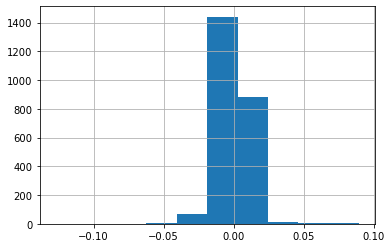

In [15]:
sp5.change.hist();

In [17]:
returns = sp5.change.values
len(returns)

2424

In [18]:
with pm.Model() as gaussian_model:
    sigma = pm.Uniform('sigma', lower=-7., upper=-3, testval=-5.3)
    pm.Normal('obs', mu=0., sd=pm.math.exp(sigma), observed=returns)

    trace = pm.sample(2000, tune=2000)

<ipython-input-18-95a715391928>:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(2000, tune=2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.6868794128642773, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8796526682320953, but should be close to 0.8. Try to increase the number of tuning steps.


In [19]:
sigma = np.mean(trace['sigma'])

print("Gaussian model parameter:")
print("Sigma = ", sigma)

Gaussian model parameter:
Sigma =  -4.553800909714164


In [20]:
interval = 100
with pm.Model() as clark_model:
    sigmaT = pm.Uniform('sigmaT', lower=0.001, upper=10., testval=0.1)
    mu = pm.Uniform('mu', lower=-7., upper=-3., testval=-5.3)

    time_process = pm.Normal('time_process', mu=mu, sd=sigmaT, shape=100)
    time_process = tt.repeat(time_process, N // interval)[:-1]

    pm.Normal('obs', mu=0., sd=pm.math.exp(time_process), observed=returns)

    trace = pm.sample(2000, tune=2000)

ValueError: Input dimension mis-match. (input[0].shape[0] = 19999, input[1].shape[0] = 2424)

In [ ]:
sigmaT = np.mean(trace['sigmaT'])
mu = np.mean(trace['mu'])

In [ ]:
print "Clark (1973) model parameters:"
print "SigmaT = ", sigmaT
print "Mu = ", mu

print "Generating Clark data..."
clark = ClarkDGP(mu, sigmaT)
print "Generating Gaussian data..."
gaussian = np.random.normal(0., np.exp(sigma), N)

print "Plotting..."

fig, axarr = plt.subplots(2, 3)

axarr[0][0].hist(gaussian)
axarr[0][0].set_title("Gaussian")

axarr[0][1].hist(clark)
axarr[0][1].set_title("Clark")

axarr[0][2].hist(returns)
axarr[0][2].set_title("Real")

axarr[1][0].plot(gaussian)
axarr[1][0].set_title("Gaussian")

axarr[1][1].plot(clark)
axarr[1][1].set_title("Clark")

axarr[1][2].plot(returns)
axarr[1][2].set_title("Real")

plt.show()